In [1]:
import pandas as pd
import soccerdata as sd

[06/29/23 16:30:24] INFO     No custom team name replacements found. You can configure these in       ]8;id=348861;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=871049;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_config.py#85\85]8;;\
                             C:\Users\Augusto\soccerdata\config\teamname_replacements.json.                        

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=521697;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=760341;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_config.py#159\159]8;;\
                             C:\Users\Augusto\soccerdata\config\league_dict.json.                                  

In [22]:
fbref = sd.FBref(leagues="ENG-Premier League", seasons=2020, no_cache=False)
schedule = fbref.read_schedule()
schedule = schedule[schedule.game_id.notna()]
schedule.loc[:, 'full_dt'] = pd.to_datetime(schedule.date.astype(str) + ' ' + schedule.time )
schedule.sort_values(by='full_dt', inplace=True)
schedule.loc[:, ['home_points', 'away_points']] = schedule.score.str.split('–', expand=True).values
schedule['home_result'] = 'draw'
schedule['away_result'] = 'draw'

schedule.loc[schedule['home_points'] > schedule['away_points'], 'home_result'] = 'win'
schedule.loc[schedule['home_points'] > schedule['away_points'], 'away_result'] = 'lose'
schedule.loc[schedule['home_points'] < schedule['away_points'], 'home_result'] = 'lose'
schedule.loc[schedule['home_points'] < schedule['away_points'], 'away_result'] = 'win'

schedule = schedule.reset_index().loc[:, ['game_id', 'home_team','away_team','home_points', 'away_points',  'home_result', 'away_result', 'full_dt']]

# DATAFRAME CONTENDO OS JOGOS ORDENADOS PELA DATA CONTENDO OS RESULTADOS PARA OS TIMES
schedule.head(5)

[06/25/23 15:39:58] INFO     Saving cached data to C:\Users\Augusto\soccerdata\data\FBref             ]8;id=870977;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=612782;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py#89\89]8;;\

,game_id,home_team,away_team,home_points,away_points,home_result,away_result,full_dt
0,bf52349b,Fulham,Arsenal,0,3,lose,win,2020-09-12 12:30:00
1,db261cb0,Crystal Palace,Southampton,1,0,win,lose,2020-09-12 15:00:00
2,21b58926,Liverpool,Leeds United,4,3,win,lose,2020-09-12 17:30:00
3,78495ced,West Ham,Newcastle Utd,0,2,lose,win,2020-09-12 20:00:00
4,7dd01ca9,West Brom,Leicester City,0,3,lose,win,2020-09-13 14:00:00


In [2]:
def aux(year):
    fbref = sd.FBref(leagues="ENG-Premier League", seasons=year, no_cache=False)
    schedule = fbref.read_schedule()
    schedule = schedule[schedule.game_id.notna()]
    schedule.loc[:, 'full_dt'] = pd.to_datetime(schedule.date.astype(str) + ' ' + schedule.time )
    schedule.sort_values(by='full_dt', inplace=True)
    schedule.loc[:, ['home_points', 'away_points']] = schedule.score.str.split('–', expand=True).values
    schedule['home_result'] = 'draw'
    schedule['away_result'] = 'draw'

    schedule.loc[schedule['home_points'] > schedule['away_points'], 'home_result'] = 'win'
    schedule.loc[schedule['home_points'] > schedule['away_points'], 'away_result'] = 'lose'
    schedule.loc[schedule['home_points'] < schedule['away_points'], 'home_result'] = 'lose'
    schedule.loc[schedule['home_points'] < schedule['away_points'], 'away_result'] = 'win'

    schedule = schedule.reset_index().loc[:, ['game_id', 'home_team','away_team','home_points', 'away_points',  'home_result', 'away_result', 'full_dt']]

    # DATAFRAME CONTENDO OS JOGOS ORDENADOS PELA DATA CONTENDO OS RESULTADOS PARA OS TIMES
    return schedule
    
schedules = {year : aux(year) for year in range(2021, 2022)}

[06/29/23 16:30:25] INFO     Saving cached data to C:\Users\Augusto\soccerdata\data\FBref             ]8;id=906436;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=851308;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py#89\89]8;;\

c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py:471: UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"
  warnings.warn(msg, stacklevel=1)


In [6]:
def match_data(match_id):
    """ get match data based on id """
    players_match_stats = fbref.read_player_match_stats(stat_type="summary", match_id=match_id)
    players_match_stats = players_match_stats.reset_index().set_index('game_id').sort_index(axis=1,sort_remaining=True)
    players_match_stats = players_match_stats.drop(columns=['season', 'league', 'nation', 'jersey_number'])
    return players_match_stats

In [4]:
def preprocess_match_data(match_data):
    pmd = pd.DataFrame()
    pmd.loc[:, 'player'] = match_data.player
    pmd.loc[:, 'team'] = match_data.team
    pmd.loc[:, 'pos'] = match_data.pos

    pmd.loc[:, 'player_age'] = match_data.age.str.split('-').str.get(0)
    pmd.loc[:, 'time_played'] = match_data['min']
    pmd.loc[:, 'shots_on_target'] = match_data[('Performance', 'SoT')]
    pmd.loc[:, 'goals'] = match_data[('Performance', 'Gls')]
    pmd.loc[:, 'touches'] = match_data[('Performance', 'Touches')]
    pmd.loc[:, 'yellow_cards'] = match_data[('Performance', 'CrdY')]
    pmd.loc[:, 'completed_passes_perc'] = match_data[('Passes', 'Cmp%')]
    
    pmd.loc[:, 'xg'] = match_data[('Expected', 'xG')]
    pmd.loc[:, 'xag'] = match_data[('Expected', 'xAG')]
                                        
    return pmd

In [5]:
# raw_matches_data = match_data(schedule.game_id.to_list())
# raw_matches_data.to_pickle('bkp_raw_matches.pkl')
raw_matches_data = pd.read_pickle('bkp_raw_matches.pkl')
matches_data = preprocess_match_data(raw_matches_data)
matches_data

,player,team,pos,player_age,time_played,shots_on_target,goals,touches,yellow_cards,completed_passes_perc,xg,xag
game_id,,,,,,,,,,,,
db261cb0,Andros Townsend,Crystal Palace,RM,29,90,0,0,38,0,43.3,0.0,0.6
db261cb0,Cheikhou Kouyaté,Crystal Palace,CB,30,90,1,0,25,0,57.9,0.2,0.0
db261cb0,Eberechi Eze,Crystal Palace,LM,22,10,0,0,13,0,80.0,0.0,0.0
db261cb0,James McArthur,Crystal Palace,CM,32,90,0,0,45,0,46.9,0.1,0.4
db261cb0,James McCarthy,Crystal Palace,CM,29,73,0,0,29,1,60.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2c081c94,Romain Saïss,Wolverhampton Wanderers,CB,31,90,0,0,90,0,88.8,0.1,0.0
2c081c94,Rui Patrício,Wolverhampton Wanderers,GK,33,90,0,0,14,0,91.7,0.0,0.0
2c081c94,Rúben Neves,Wolverhampton Wanderers,CM,24,90,0,0,98,0,86.0,0.1,0.1


In [6]:
for year, schedule in schedules.items():
    print(year)
    fbref = sd.FBref(leagues="ENG-Premier League", seasons=year, no_cache=False)
    raw_matches_data = match_data(schedule.game_id.to_list())
    raw_matches_data.to_pickle(f'matches_tmp/bkp_raw_matches_{year}.pkl')

2021


[06/29/23 16:30:39] INFO     Saving cached data to C:\Users\Augusto\soccerdata\data\FBref             ]8;id=94030;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=190198;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py#89\89]8;;\

c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py:471: UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"
  warnings.warn(msg, stacklevel=1)


NameError: name 'match_data' is not defined

In [7]:

positions = set(','.join(matches_data.pos).split(','))
positions = {
    'AM': 'Attacking Midfielder',# considera
    'CB': 'Center Back',
    'CM': 'Center Midfielder',# considera
    'DF': 'Defense',
    'DM': 'Defense Midfielder',
    'FW': 'Forward',# considera
    'GK': 'Goalkeeper',
    'LB': 'Left Back',
    'LM': 'Left Midfielder',# considera
    'LW': 'Left Wing', # considera
    'MF': 'Midfielder',# considera
    'RB': 'Right Back',
    'RM': 'Right Midfielder',# considera
    'RW': 'Right Wing', # considera
    'WB': 'Wing Back'
}


['CM', 'LM', 'RM', 'MF', 'FW', 'AM']

In [11]:

import numpy as np 

full_train_data = []
for year, schedule in schedules.items():
    if year < 2017:
        continue
    raw_matches_data = pd.read_pickle(f'matches_tmp/bkp_raw_matches_{year}.pkl')
    matches_data = preprocess_match_data(raw_matches_data)
    df = pd.merge(left=schedule, right=matches_data, left_on='game_id', right_index=True)
    print(year, df.full_dt.max())

    train_data = df.copy()
    train_data.loc[:, 'result'] = np.where(train_data.team == train_data.home_team, train_data.home_result, train_data.away_result)
    # train_data.drop(columns=['home_points', 'away_points', 'home_result', 'away_result'], inplace=True)

    for c in ['time_played', 'shots_on_target', 'goals', 'touches', 'yellow_cards', 'completed_passes_perc', 'result']:
        train_data['last_' + c] = train_data.groupby('player')[c].shift().fillna(0)
        
    for c in ['xg', 'xag',  'full_dt']:
        train_data['last_' + c] = train_data.groupby('player')[c].shift()

    train_data.loc[:, 'days_from_last_game'] = (train_data['full_dt'] - train_data.last_full_dt).dt.days.fillna(14.0)
    train_data.last_xg.fillna(0, inplace=True)
    train_data.last_xag.fillna(0, inplace=True)

    train_data.loc[:, 'played_at_home'] = train_data.team == train_data.home_team
    train_data.loc[:, 'Season_End_Year'] = year+1
    
    # train_data.drop(columns=['full_dt', 'last_full_dt'], inplace=True)
    
    full_train_data.append(train_data)
    
full_train_df = pd.concat(full_train_data)
full_train_df

2021 2021-05-23 16:00:00


,game_id,home_team,away_team,home_points,away_points,home_result,away_result,full_dt,player,team,...,last_touches,last_yellow_cards,last_completed_passes_perc,last_result,last_xg,last_xag,last_full_dt,days_from_last_game,played_at_home,Season_End_Year
0,bf52349b,Fulham,Arsenal,0,3,lose,win,2020-09-12 12:30:00,Ainsley Maitland-Niles,Arsenal,...,0.0,0.0,0.0,0,0.0,0.0,NaT,14.0,False,2022
0,bf52349b,Fulham,Arsenal,0,3,lose,win,2020-09-12 12:30:00,Alexandre Lacazette,Arsenal,...,0.0,0.0,0.0,0,0.0,0.0,NaT,14.0,False,2022
0,bf52349b,Fulham,Arsenal,0,3,lose,win,2020-09-12 12:30:00,Bernd Leno,Arsenal,...,0.0,0.0,0.0,0,0.0,0.0,NaT,14.0,False,2022
0,bf52349b,Fulham,Arsenal,0,3,lose,win,2020-09-12 12:30:00,Dani Ceballos,Arsenal,...,0.0,0.0,0.0,0,0.0,0.0,NaT,14.0,False,2022
0,bf52349b,Fulham,Arsenal,0,3,lose,win,2020-09-12 12:30:00,Eddie Nketiah,Arsenal,...,0.0,0.0,0.0,0,0.0,0.0,NaT,14.0,False,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,2c081c94,Wolves,Manchester Utd,1,2,lose,win,2021-05-23 16:00:00,Romain Saïss,Wolverhampton Wanderers,...,61.0,0.0,75.5,lose,0.2,0.0,2021-05-16 14:05:00,7.0,False,2022
379,2c081c94,Wolves,Manchester Utd,1,2,lose,win,2021-05-23 16:00:00,Rui Patrício,Wolverhampton Wanderers,...,26.0,0.0,77.3,lose,0.0,0.0,2021-05-16 14:05:00,7.0,False,2022
379,2c081c94,Wolves,Manchester Utd,1,2,lose,win,2021-05-23 16:00:00,Rúben Neves,Wolverhampton Wanderers,...,91.0,1.0,86.3,lose,0.0,0.0,2021-05-19 18:00:00,3.0,False,2022
379,2c081c94,Wolves,Manchester Utd,1,2,lose,win,2021-05-23 16:00:00,Willian José,Wolverhampton Wanderers,...,14.0,0.0,44.4,lose,0.0,0.0,2021-05-19 18:00:00,3.0,False,2022


In [12]:
full_train_df.to_csv('input_data.csv')

In [13]:
ws = sd.WhoScored('ENG-Premier League', seasons=2021, no_cache=False)

[06/29/23 16:32:43] INFO     Saving cached data to C:\Users\Augusto\soccerdata\data\WhoScored         ]8;id=150846;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=784604;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py#89\89]8;;\

c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py:471: UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"
  warnings.warn(msg, stacklevel=1)


In [14]:
epl_schedule = pd.read_pickle('bkp_premier_league_2021_whoscored.pkl')
# para ser usado no epl schedule
epl_rename_map = {
    'Leeds' : 'Leeds United',
    'Leicester': 'Leicester City',
    'Manchester United': 'Manchester Utd',
    'Newcastle': 'Newcastle Utd' ,
    'Sheffield United': 'Sheffield Utd',
    'West Bromwich': 'West Brom',
    'Wolverhampton': 'Wolves'
}
epl_schedule.home_team = epl_schedule.home_team.replace(epl_rename_map)
epl_schedule.away_team = epl_schedule.away_team.replace(epl_rename_map)
epl_schedule

date  \
league             season game                                                             
ENG-Premier League 2021   2020-09-12 Crystal Palace-Southampton      2020-09-12 15:00:00   
                          2020-09-12 Fulham-Arsenal                  2020-09-12 12:30:00   
                          2020-09-12 Liverpool-Leeds                 2020-09-12 17:30:00   
                          2020-09-12 West Ham-Newcastle              2020-09-12 20:00:00   
                          2020-09-13 Tottenham-Everton               2020-09-13 16:30:00   
...                                                                                  ...   
                          2021-05-23 Liverpool-Crystal Palace        2021-05-23 16:00:00   
                          2021-05-23 Manchester City-Everton         2021-05-23 16:00:00   
                          2021-05-23 Sheffield United-Burnley        2021-05-23 16:00:00   
                          2021-05-23 West Ham-Southampton            2021-05-23 16:00:00   
                          2021-05-23 Wolverhampton-Manchester United 2021-05-23 16:00:00   

                                                                            home_team  \
league             season game                                                          
ENG-Premier League 2021   2020-09-12 Crystal Palace-Southampton        Crystal Palace   
                          2020-09-12 Fulham-Arsenal                            Fulham   
                          2020-09-12 Liverpool-Leeds                        Liverpool   
                          2020-09-12 West Ham-Newcastle                      West Ham   
                          2020-09-13 Tottenham-Everton                      Tottenham   
...                                                                               ...   
                          2021-05-23 Liverpool-Crystal Palace               Liverpool   
                          2021-05-23 Manchester City-Everton          Manchester City   
                          2021-05-23 Sheffield United-Burnley           Sheffield Utd   
                          2021-05-23 West Ham-Southampton                    West Ham   
                          2021-05-23 Wolverhampton-Manchester United           Wolves   

                                                                           away_team  \
league             season game                                                         
ENG-Premier League 2021   2020-09-12 Crystal Palace-Southampton          Southampton   
                          2020-09-12 Fulham-Arsenal                          Arsenal   
                          2020-09-12 Liverpool-Leeds                    Leeds United   
                          2020-09-12 West Ham-Newcastle                Newcastle Utd   
                          2020-09-13 Tottenham-Everton                       Everton   
...                                                                              ...   
                          2021-05-23 Liverpool-Crystal Palace         Crystal Palace   
                          2021-05-23 Manchester City-Everton                 Everton   
                          2021-05-23 Sheffield United-Burnley                Burnley   
                          2021-05-23 West Ham-Southampton                Southampton   
                          2021-05-23 Wolverhampton-Manchester United  Manchester Utd   

                                                                      game_id  \
league             season game                                                  
ENG-Premier League 2021   2020-09-12 Crystal Palace-Southampton       1485186   
                          2020-09-12 Fulham-Arsenal                   1485187   
                          2020-09-12 Liverpool-Leeds                  1485188   
                          2020-09-12 West Ham-Newcastle               1485191   
                          2020-09-13 Tottenham-Everton                1485189   
...              

In [15]:
schedule = schedules[2021]
schedule.to_pickle('schedule2021.pkl')
joined_schedule = epl_schedule.merge(schedule, on=['home_team', 'away_team'])
print(joined_schedule.shape)
joined_schedule.head(5)

(380, 12)


,date,home_team,away_team,game_id_x,url,stage,game_id_y,home_points,away_points,home_result,away_result,full_dt
0,2020-09-12 15:00:00,Crystal Palace,Southampton,1485186,https://1xbet.whoscored.com/Matches/1485186/Li...,None,db261cb0,1,0,win,lose,2020-09-12 15:00:00
1,2020-09-12 12:30:00,Fulham,Arsenal,1485187,https://1xbet.whoscored.com/Matches/1485187/Li...,None,bf52349b,0,3,lose,win,2020-09-12 12:30:00
2,2020-09-12 17:30:00,Liverpool,Leeds United,1485188,https://1xbet.whoscored.com/Matches/1485188/Li...,None,21b58926,4,3,win,lose,2020-09-12 17:30:00
3,2020-09-12 20:00:00,West Ham,Newcastle Utd,1485191,https://1xbet.whoscored.com/Matches/1485191/Li...,None,78495ced,0,2,lose,win,2020-09-12 20:00:00
4,2020-09-13 16:30:00,Tottenham,Everton,1485189,https://1xbet.whoscored.com/Matches/1485189/Li...,None,fc7f9aa1,0,1,lose,win,2020-09-13 16:30:00


In [112]:
ws = sd.WhoScored('ENG-Premier League', seasons=2021, no_cache=False)
all_matches = ws.read_events(match_id=joined_schedule.game_id_x.tolist(), output_fmt='spadl')


[06/25/23 18:57:04] INFO     Saving cached data to C:\Users\Augusto\soccerdata\data\WhoScored         ]8;id=627630;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=661560;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py#89\89]8;;\

c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\_common.py:471: UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"
  warnings.warn(msg, stacklevel=1)


[06/25/23 18:57:05] INFO     Retrieving game schedule of ENG-Premier League - 2021 from the cache  ]8;id=779661;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=835480;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#434\434]8;;\

                    INFO     [1/380] Retrieving game with id=1485186                               ]8;id=892802;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=740609;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:06] INFO     [2/380] Retrieving game with id=1485187                               ]8;id=132698;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=435972;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:07] INFO     [3/380] Retrieving game with id=1485188                               ]8;id=186525;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=478842;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [4/380] Retrieving game with id=1485191                               ]8;id=349697;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=576606;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [5/380] Retrieving game with id=1485189                               ]8;id=975025;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=385850;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [6/380] Retrieving game with id=1485190                               ]8;id=111051;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=439969;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:08] INFO     [7/380] Retrieving game with id=1485192                               ]8;id=797198;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=308740;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [8/380] Retrieving game with id=1485193                               ]8;id=65138;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=367584;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [9/380] Retrieving game with id=1485194                               ]8;id=729241;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=404149;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:09] INFO     [10/380] Retrieving game with id=1485197                              ]8;id=108182;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=925999;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [11/380] Retrieving game with id=1485198                              ]8;id=941986;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=822044;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [12/380] Retrieving game with id=1485200                              ]8;id=762203;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=19565;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [13/380] Retrieving game with id=1485196                              ]8;id=534210;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=937807;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:10] INFO     [14/380] Retrieving game with id=1485199                              ]8;id=880448;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=988220;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [15/380] Retrieving game with id=1485201                              ]8;id=883968;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=820146;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [16/380] Retrieving game with id=1485202                              ]8;id=45014;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=690313;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:11] INFO     [17/380] Retrieving game with id=1485195                              ]8;id=249147;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=201232;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [18/380] Retrieving game with id=1485203                              ]8;id=250545;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=846007;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [19/380] Retrieving game with id=1485204                              ]8;id=928778;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=321554;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:12] INFO     [20/380] Retrieving game with id=1485205                              ]8;id=266917;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=514974;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [21/380] Retrieving game with id=1485206                              ]8;id=901512;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=594193;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [22/380] Retrieving game with id=1485212                              ]8;id=785714;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=932864;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [23/380] Retrieving game with id=1485209                              ]8;id=41907;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=14828;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:13] INFO     [24/380] Retrieving game with id=1485210                              ]8;id=896782;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=340973;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [25/380] Retrieving game with id=1485211                              ]8;id=814212;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=53191;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [26/380] Retrieving game with id=1485213                              ]8;id=978757;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=874596;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:14] INFO     [27/380] Retrieving game with id=1485207                              ]8;id=510649;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=970497;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [28/380] Retrieving game with id=1485208                              ]8;id=540636;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=853420;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [29/380] Retrieving game with id=1485216                              ]8;id=167690;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=548987;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:15] INFO     [30/380] Retrieving game with id=1485217                              ]8;id=196437;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=728362;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [31/380] Retrieving game with id=1485218                              ]8;id=958550;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=2174;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:16] INFO     [32/380] Retrieving game with id=1485221                              ]8;id=806804;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=37106;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [33/380] Retrieving game with id=1485214                              ]8;id=17987;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=56580;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [34/380] Retrieving game with id=1485215                              ]8;id=721278;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=227548;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [35/380] Retrieving game with id=1485219                              ]8;id=631954;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=214316;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:17] INFO     [36/380] Retrieving game with id=1485220                              ]8;id=909495;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=855415;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [37/380] Retrieving game with id=1485222                              ]8;id=283045;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=521372;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:18] INFO     [38/380] Retrieving game with id=1485223                              ]8;id=392550;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=826954;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [39/380] Retrieving game with id=1485224                              ]8;id=334420;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=473087;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [40/380] Retrieving game with id=1485226                              ]8;id=936419;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=38217;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [41/380] Retrieving game with id=1485229                              ]8;id=522309;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=927098;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [42/380] Retrieving game with id=1485230                              ]8;id=193185;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=336095;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:19] INFO     [43/380] Retrieving game with id=1485225                              ]8;id=728526;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=956977;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [44/380] Retrieving game with id=1485228                              ]8;id=142007;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=323237;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [45/380] Retrieving game with id=1485231                              ]8;id=411621;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=677868;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:20] INFO     [46/380] Retrieving game with id=1485232                              ]8;id=696334;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=336501;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [47/380] Retrieving game with id=1485227                              ]8;id=651511;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=732464;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [48/380] Retrieving game with id=1485233                              ]8;id=424008;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=176778;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [49/380] Retrieving game with id=1485235                              ]8;id=436346;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=539053;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:21] INFO     [50/380] Retrieving game with id=1485239                              ]8;id=299436;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=862681;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [51/380] Retrieving game with id=1485241                              ]8;id=934589;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=91362;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:22] INFO     [52/380] Retrieving game with id=1485243                              ]8;id=796253;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=452758;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [53/380] Retrieving game with id=1485247                              ]8;id=628259;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=342794;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [54/380] Retrieving game with id=1485234                              ]8;id=333129;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=651290;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [55/380] Retrieving game with id=1485245                              ]8;id=812122;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=809867;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:23] INFO     [56/380] Retrieving game with id=1485249                              ]8;id=717546;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=947108;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [57/380] Retrieving game with id=1485236                              ]8;id=285470;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=253995;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [58/380] Retrieving game with id=1485237                              ]8;id=621270;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=301471;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:24] INFO     [59/380] Retrieving game with id=1485269                              ]8;id=56318;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=698878;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [60/380] Retrieving game with id=1485253                              ]8;id=158329;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=546243;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [61/380] Retrieving game with id=1485259                              ]8;id=860000;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=746696;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [62/380] Retrieving game with id=1485265                              ]8;id=264043;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=358058;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:25] INFO     [63/380] Retrieving game with id=1485251                              ]8;id=358483;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=768253;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [64/380] Retrieving game with id=1485261                              ]8;id=933818;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=752919;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [65/380] Retrieving game with id=1485263                              ]8;id=245807;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=287919;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [66/380] Retrieving game with id=1485267                              ]8;id=205323;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=679736;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:26] INFO     [67/380] Retrieving game with id=1485255                              ]8;id=223831;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=670146;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [68/380] Retrieving game with id=1485257                              ]8;id=88128;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=872273;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [69/380] Retrieving game with id=1485273                              ]8;id=753205;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=95001;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [70/380] Retrieving game with id=1485285                              ]8;id=792031;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=530307;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:27] INFO     [71/380] Retrieving game with id=1485275                              ]8;id=481973;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=154443;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [72/380] Retrieving game with id=1485277                              ]8;id=807800;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=834975;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [73/380] Retrieving game with id=1485279                              ]8;id=431127;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=279509;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:28] INFO     [74/380] Retrieving game with id=1485289                              ]8;id=758599;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=473715;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [75/380] Retrieving game with id=1485271                              ]8;id=146359;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=282768;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [76/380] Retrieving game with id=1485281                              ]8;id=891083;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=705186;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [77/380] Retrieving game with id=1485283                              ]8;id=999503;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=535826;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:29] INFO     [78/380] Retrieving game with id=1485287                              ]8;id=437035;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=727578;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [79/380] Retrieving game with id=1485291                              ]8;id=179221;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=459062;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [80/380] Retrieving game with id=1485301                              ]8;id=411936;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=463983;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [81/380] Retrieving game with id=1485303                              ]8;id=831026;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=802306;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:30] INFO     [82/380] Retrieving game with id=1485307                              ]8;id=104145;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=694568;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [83/380] Retrieving game with id=1485295                              ]8;id=874150;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=252389;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [84/380] Retrieving game with id=1485297                              ]8;id=205610;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=962473;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [85/380] Retrieving game with id=1485299                              ]8;id=598462;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=551730;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [86/380] Retrieving game with id=1485305                              ]8;id=371740;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=316424;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:31] INFO     [87/380] Retrieving game with id=1485293                              ]8;id=915010;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=94712;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [88/380] Retrieving game with id=1485309                              ]8;id=921553;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=183815;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:32] INFO     [89/380] Retrieving game with id=1485242                              ]8;id=355862;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=785163;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [90/380] Retrieving game with id=1485238                              ]8;id=650118;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=295669;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [91/380] Retrieving game with id=1485244                              ]8;id=604761;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=122358;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:33] INFO     [92/380] Retrieving game with id=1485248                              ]8;id=179482;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=733624;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [93/380] Retrieving game with id=1485252                              ]8;id=995185;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=920540;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [94/380] Retrieving game with id=1485311                              ]8;id=297949;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=533704;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:34] INFO     [95/380] Retrieving game with id=1485240                              ]8;id=59047;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=760206;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [96/380] Retrieving game with id=1485250                              ]8;id=347780;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=340878;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [97/380] Retrieving game with id=1485246                              ]8;id=152889;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=610011;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [98/380] Retrieving game with id=1485254                              ]8;id=317449;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=161810;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [99/380] Retrieving game with id=1485260                              ]8;id=939125;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=3215;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:35] INFO     [100/380] Retrieving game with id=1485262                             ]8;id=668426;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=332754;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [101/380] Retrieving game with id=1485266                             ]8;id=515898;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=835300;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [102/380] Retrieving game with id=1485274                             ]8;id=390902;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=590264;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:36] INFO     [103/380] Retrieving game with id=1485264                             ]8;id=8345;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=985776;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [104/380] Retrieving game with id=1485268                             ]8;id=503505;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=554767;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [105/380] Retrieving game with id=1485270                             ]8;id=768066;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=502601;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [106/380] Retrieving game with id=1485272                             ]8;id=185092;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=527507;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [107/380] Retrieving game with id=1485258                             ]8;id=253782;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=400251;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:37] INFO     [108/380] Retrieving game with id=1485284                             ]8;id=453756;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=913794;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [109/380] Retrieving game with id=1485280                             ]8;id=106810;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=289055;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [110/380] Retrieving game with id=1485288                             ]8;id=292910;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=399953;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:38] INFO     [111/380] Retrieving game with id=1485290                             ]8;id=993646;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=932456;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [112/380] Retrieving game with id=1485294                             ]8;id=945441;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=138475;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [113/380] Retrieving game with id=1485276                             ]8;id=725159;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=660932;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [114/380] Retrieving game with id=1485278                             ]8;id=43662;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=922386;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [115/380] Retrieving game with id=1485282                             ]8;id=447960;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=420243;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:39] INFO     [116/380] Retrieving game with id=1485286                             ]8;id=702755;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=916222;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [117/380] Retrieving game with id=1485292                             ]8;id=570632;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=748753;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:40] INFO     [118/380] Retrieving game with id=1485313                             ]8;id=476341;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=331254;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [119/380] Retrieving game with id=1485310                             ]8;id=784581;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=617767;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [120/380] Retrieving game with id=1485296                             ]8;id=171771;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=772671;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [121/380] Retrieving game with id=1485300                             ]8;id=111007;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=122452;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:41] INFO     [122/380] Retrieving game with id=1485302                             ]8;id=274998;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=514197;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [123/380] Retrieving game with id=1485304                             ]8;id=932240;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=81663;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:42] INFO     [124/380] Retrieving game with id=1485312                             ]8;id=237353;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=841442;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [125/380] Retrieving game with id=1485308                             ]8;id=172689;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=108912;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [126/380] Retrieving game with id=1485298                             ]8;id=602151;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=916245;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [127/380] Retrieving game with id=1485306                             ]8;id=794644;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=87507;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:43] INFO     [128/380] Retrieving game with id=1485317                             ]8;id=883140;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=168940;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [129/380] Retrieving game with id=1485318                             ]8;id=924368;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=835459;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [130/380] Retrieving game with id=1485320                             ]8;id=145110;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=728564;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [131/380] Retrieving game with id=1485451                             ]8;id=794980;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=954347;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:44] INFO     [132/380] Retrieving game with id=1485314                             ]8;id=364458;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=305461;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [133/380] Retrieving game with id=1485319                             ]8;id=670741;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=253567;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [134/380] Retrieving game with id=1485453                             ]8;id=701638;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=836443;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:45] INFO     [135/380] Retrieving game with id=1485455                             ]8;id=572973;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=438629;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [136/380] Retrieving game with id=1485315                             ]8;id=135539;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=854028;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [137/380] Retrieving game with id=1485316                             ]8;id=311601;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=929675;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [138/380] Retrieving game with id=1485457                             ]8;id=619475;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=559154;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:46] INFO     [139/380] Retrieving game with id=1485459                             ]8;id=714860;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=591533;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [140/380] Retrieving game with id=1485461                             ]8;id=139843;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=328467;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [141/380] Retrieving game with id=1485444                             ]8;id=631607;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=207951;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:47] INFO     [142/380] Retrieving game with id=1485446                             ]8;id=299205;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=370803;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [143/380] Retrieving game with id=1485447                             ]8;id=771136;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=653985;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [144/380] Retrieving game with id=1485463                             ]8;id=202609;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=103092;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [145/380] Retrieving game with id=1485445                             ]8;id=367684;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=470102;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:48] INFO     [146/380] Retrieving game with id=1485448                             ]8;id=588784;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=768649;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [147/380] Retrieving game with id=1485449                             ]8;id=477636;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=197820;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [148/380] Retrieving game with id=1485454                             ]8;id=503492;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=266547;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:49] INFO     [149/380] Retrieving game with id=1485456                             ]8;id=517631;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=701769;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [150/380] Retrieving game with id=1485450                             ]8;id=817751;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=385916;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [151/380] Retrieving game with id=1485452                             ]8;id=842374;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=906930;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [152/380] Retrieving game with id=1485460                             ]8;id=510817;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=844303;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:50] INFO     [153/380] Retrieving game with id=1485464                             ]8;id=446514;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=17703;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [154/380] Retrieving game with id=1485466                             ]8;id=379273;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=837815;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [155/380] Retrieving game with id=1485462                             ]8;id=872522;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=294206;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:51] INFO     [156/380] Retrieving game with id=1485321                             ]8;id=737064;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=608760;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [157/380] Retrieving game with id=1485323                             ]8;id=873311;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=393947;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [158/380] Retrieving game with id=1485467                             ]8;id=213737;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=896352;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [159/380] Retrieving game with id=1485470                             ]8;id=326178;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=572080;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:52] INFO     [160/380] Retrieving game with id=1485332                             ]8;id=686221;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=138718;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [161/380] Retrieving game with id=1485335                             ]8;id=486105;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=63702;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [162/380] Retrieving game with id=1485469                             ]8;id=604555;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=27911;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:53] INFO     [163/380] Retrieving game with id=1485326                             ]8;id=746289;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=163794;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [164/380] Retrieving game with id=1485329                             ]8;id=444891;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=869542;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [165/380] Retrieving game with id=1485184                             ]8;id=687391;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=167477;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [166/380] Retrieving game with id=1485353                             ]8;id=706683;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=309851;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:54] INFO     [167/380] Retrieving game with id=1485359                             ]8;id=372505;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=59937;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [168/380] Retrieving game with id=1485365                             ]8;id=874343;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=135973;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:55] INFO     [169/380] Retrieving game with id=1485465                             ]8;id=627100;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=878741;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [170/380] Retrieving game with id=1485338                             ]8;id=233651;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=881381;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [171/380] Retrieving game with id=1485374                             ]8;id=706253;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=658135;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:56] INFO     [172/380] Retrieving game with id=1485377                             ]8;id=159371;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=27444;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [173/380] Retrieving game with id=1485380                             ]8;id=698504;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=495478;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [174/380] Retrieving game with id=1485392                             ]8;id=575377;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=977644;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:57] INFO     [175/380] Retrieving game with id=1485395                             ]8;id=462047;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=858709;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [176/380] Retrieving game with id=1485383                             ]8;id=214035;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=653970;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [177/380] Retrieving game with id=1485386                             ]8;id=979676;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=967451;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:58] INFO     [178/380] Retrieving game with id=1485389                             ]8;id=216009;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=144226;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [179/380] Retrieving game with id=1485368                             ]8;id=269824;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=198308;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [180/380] Retrieving game with id=1485350                             ]8;id=813334;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=923444;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [181/380] Retrieving game with id=1485356                             ]8;id=163678;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=125387;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:57:59] INFO     [182/380] Retrieving game with id=1485344                             ]8;id=111264;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=183263;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [183/380] Retrieving game with id=1485185                             ]8;id=39822;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=647287;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [184/380] Retrieving game with id=1485362                             ]8;id=171439;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=785746;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [185/380] Retrieving game with id=1485256                             ]8;id=124878;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=200107;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:00] INFO     [186/380] Retrieving game with id=1485425                             ]8;id=834653;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=29042;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [187/380] Retrieving game with id=1485416                             ]8;id=380808;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=770919;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [188/380] Retrieving game with id=1485419                             ]8;id=908372;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=58572;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:01] INFO     [189/380] Retrieving game with id=1485410                             ]8;id=587367;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=191950;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [190/380] Retrieving game with id=1485398                             ]8;id=460476;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=192467;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [191/380] Retrieving game with id=1485401                             ]8;id=129350;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=854621;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:02] INFO     [192/380] Retrieving game with id=1485413                             ]8;id=839333;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=661458;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [193/380] Retrieving game with id=1485404                             ]8;id=448538;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=214847;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [194/380] Retrieving game with id=1485407                             ]8;id=24365;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=53250;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [195/380] Retrieving game with id=1485422                             ]8;id=71721;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=930342;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:03] INFO     [196/380] Retrieving game with id=1485428                             ]8;id=77543;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=912708;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [197/380] Retrieving game with id=1485437                             ]8;id=720754;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=524998;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:04] INFO     [198/380] Retrieving game with id=1485322                             ]8;id=7854;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=65262;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [199/380] Retrieving game with id=1485327                             ]8;id=369306;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=868192;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [200/380] Retrieving game with id=1485330                             ]8;id=132986;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=220253;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [201/380] Retrieving game with id=1485333                             ]8;id=573930;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=795036;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [202/380] Retrieving game with id=1485431                             ]8;id=290290;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=229642;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:05] INFO     [203/380] Retrieving game with id=1485434                             ]8;id=875973;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=682347;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [204/380] Retrieving game with id=1485324                             ]8;id=659263;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=561675;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [205/380] Retrieving game with id=1485336                             ]8;id=838700;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=594507;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:06] INFO     [206/380] Retrieving game with id=1485357                             ]8;id=287246;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=273979;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [207/380] Retrieving game with id=1485360                             ]8;id=816187;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=373497;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [208/380] Retrieving game with id=1485351                             ]8;id=148858;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=828617;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [209/380] Retrieving game with id=1485354                             ]8;id=881452;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=991743;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [210/380] Retrieving game with id=1485339                             ]8;id=995591;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=731691;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:07] INFO     [211/380] Retrieving game with id=1485342                             ]8;id=58311;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=11463;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [212/380] Retrieving game with id=1485345                             ]8;id=851595;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=999450;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:08] INFO     [213/380] Retrieving game with id=1485348                             ]8;id=631064;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=382431;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [214/380] Retrieving game with id=1485366                             ]8;id=204266;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=619754;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [215/380] Retrieving game with id=1485363                             ]8;id=495293;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=512934;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [216/380] Retrieving game with id=1485369                             ]8;id=49392;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=171627;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:09] INFO     [217/380] Retrieving game with id=1485372                             ]8;id=449305;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=152501;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [218/380] Retrieving game with id=1485375                             ]8;id=582020;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=923117;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [219/380] Retrieving game with id=1485384                             ]8;id=795923;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=879659;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:10] INFO     [220/380] Retrieving game with id=1485387                             ]8;id=198764;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=603302;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [221/380] Retrieving game with id=1485381                             ]8;id=344307;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=590339;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [222/380] Retrieving game with id=1485390                             ]8;id=928656;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=580751;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:11] INFO     [223/380] Retrieving game with id=1485393                             ]8;id=279287;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=903421;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [224/380] Retrieving game with id=1485396                             ]8;id=492712;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=458708;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [225/380] Retrieving game with id=1485378                             ]8;id=400301;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=84657;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:12] INFO     [226/380] Retrieving game with id=1485402                             ]8;id=788152;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=664091;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [227/380] Retrieving game with id=1485408                             ]8;id=419716;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=475847;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [228/380] Retrieving game with id=1485414                             ]8;id=189289;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=28116;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [229/380] Retrieving game with id=1485417                             ]8;id=309647;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=100543;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [230/380] Retrieving game with id=1485399                             ]8;id=80882;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=290464;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [231/380] Retrieving game with id=1485411                             ]8;id=972270;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=423373;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:13] INFO     [232/380] Retrieving game with id=1485420                             ]8;id=152394;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=188466;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [233/380] Retrieving game with id=1485423                             ]8;id=798383;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=707133;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [234/380] Retrieving game with id=1485405                             ]8;id=87334;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=147845;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:14] INFO     [235/380] Retrieving game with id=1485426                             ]8;id=157015;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=704446;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [236/380] Retrieving game with id=1485468                             ]8;id=92256;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=416478;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [237/380] Retrieving game with id=1485458                             ]8;id=537551;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=938956;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [238/380] Retrieving game with id=1485334                             ]8;id=537990;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=52350;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [239/380] Retrieving game with id=1485438                             ]8;id=964752;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=588917;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:15] INFO     [240/380] Retrieving game with id=1485440                             ]8;id=625087;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=979576;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [241/380] Retrieving game with id=1485442                             ]8;id=117244;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=754395;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [242/380] Retrieving game with id=1485328                             ]8;id=237985;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=532437;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [243/380] Retrieving game with id=1485429                             ]8;id=101573;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=431443;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:16] INFO     [244/380] Retrieving game with id=1485432                             ]8;id=509465;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=605082;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [245/380] Retrieving game with id=1485325                             ]8;id=421781;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=729549;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [246/380] Retrieving game with id=1485331                             ]8;id=86360;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=35928;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:17] INFO     [247/380] Retrieving game with id=1485435                             ]8;id=146728;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=680058;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [248/380] Retrieving game with id=1485347                             ]8;id=579879;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=718953;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [249/380] Retrieving game with id=1485346                             ]8;id=932496;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=688837;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [250/380] Retrieving game with id=1485352                             ]8;id=682583;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=600718;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [251/380] Retrieving game with id=1485355                             ]8;id=553663;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=286908;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [252/380] Retrieving game with id=1485364                             ]8;id=108829;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=117823;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:18] INFO     [253/380] Retrieving game with id=1485337                             ]8;id=992288;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=748638;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [254/380] Retrieving game with id=1485340                             ]8;id=227752;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=655034;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [255/380] Retrieving game with id=1485349                             ]8;id=464883;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=443998;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:19] INFO     [256/380] Retrieving game with id=1485358                             ]8;id=45113;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=762542;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [257/380] Retrieving game with id=1485361                             ]8;id=4171;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=247684;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [258/380] Retrieving game with id=1485343                             ]8;id=572567;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=683969;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [259/380] Retrieving game with id=1485441                             ]8;id=403259;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=493014;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [260/380] Retrieving game with id=1485430                             ]8;id=435415;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=491314;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [261/380] Retrieving game with id=1485433                             ]8;id=553080;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=786226;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:20] INFO     [262/380] Retrieving game with id=1485443                             ]8;id=923054;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=429708;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [263/380] Retrieving game with id=1485542                             ]8;id=810072;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=664517;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [264/380] Retrieving game with id=1485439                             ]8;id=417953;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=970849;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [265/380] Retrieving game with id=1485474                             ]8;id=107832;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=448729;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:21] INFO     [266/380] Retrieving game with id=1485367                             ]8;id=426362;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=703200;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [267/380] Retrieving game with id=1485370                             ]8;id=665032;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=46533;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [268/380] Retrieving game with id=1485373                             ]8;id=451807;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=895178;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [269/380] Retrieving game with id=1485385                             ]8;id=21893;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=506411;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:22] INFO     [270/380] Retrieving game with id=1485379                             ]8;id=884980;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=339194;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [271/380] Retrieving game with id=1485382                             ]8;id=280265;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=747812;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [272/380] Retrieving game with id=1485388                             ]8;id=85055;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=638628;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [273/380] Retrieving game with id=1485391                             ]8;id=189657;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=395772;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:23] INFO     [274/380] Retrieving game with id=1485376                             ]8;id=138704;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=172215;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [275/380] Retrieving game with id=1485394                             ]8;id=119253;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=299758;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [276/380] Retrieving game with id=1485550                             ]8;id=557325;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=390141;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [277/380] Retrieving game with id=1485418                             ]8;id=483865;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=612729;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:24] INFO     [278/380] Retrieving game with id=1485400                             ]8;id=220539;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=995390;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [279/380] Retrieving game with id=1485403                             ]8;id=944099;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=749364;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [280/380] Retrieving game with id=1485406                             ]8;id=680097;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=186818;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [281/380] Retrieving game with id=1485409                             ]8;id=43870;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=608435;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [282/380] Retrieving game with id=1485397                             ]8;id=719188;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=288325;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:25] INFO     [283/380] Retrieving game with id=1485412                             ]8;id=12295;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=454584;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [284/380] Retrieving game with id=1485415                             ]8;id=19030;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=916727;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [285/380] Retrieving game with id=1485421                             ]8;id=747389;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=311848;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:26] INFO     [286/380] Retrieving game with id=1485424                             ]8;id=659568;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=15605;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [287/380] Retrieving game with id=1485436                             ]8;id=829433;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=890966;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [288/380] Retrieving game with id=1485427                             ]8;id=596303;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=119630;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [289/380] Retrieving game with id=1485341                             ]8;id=220852;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=39556;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [290/380] Retrieving game with id=1485476                             ]8;id=155569;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=755272;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:27] INFO     [291/380] Retrieving game with id=1485478                             ]8;id=177328;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=837083;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [292/380] Retrieving game with id=1485482                             ]8;id=631401;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=277943;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [293/380] Retrieving game with id=1485486                             ]8;id=767147;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=122058;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [294/380] Retrieving game with id=1485488                             ]8;id=555897;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=32183;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [295/380] Retrieving game with id=1485480                             ]8;id=827489;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=293373;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:28] INFO     [296/380] Retrieving game with id=1485490                             ]8;id=260761;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=278256;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [297/380] Retrieving game with id=1485492                             ]8;id=815975;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=220395;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [298/380] Retrieving game with id=1485494                             ]8;id=469871;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=400224;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:29] INFO     [299/380] Retrieving game with id=1485484                             ]8;id=862218;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=735710;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [300/380] Retrieving game with id=1485496                             ]8;id=107212;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=827377;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [301/380] Retrieving game with id=1485504                             ]8;id=23647;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=366420;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [302/380] Retrieving game with id=1485502                             ]8;id=80152;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=755108;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [303/380] Retrieving game with id=1485506                             ]8;id=54461;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=131264;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:30] INFO     [304/380] Retrieving game with id=1485508                             ]8;id=665529;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=836652;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [305/380] Retrieving game with id=1485500                             ]8;id=917468;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=907623;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [306/380] Retrieving game with id=1485510                             ]8;id=910769;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=561249;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [307/380] Retrieving game with id=1485512                             ]8;id=160741;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=74181;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:31] INFO     [308/380] Retrieving game with id=1485516                             ]8;id=66283;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=2869;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [309/380] Retrieving game with id=1485498                             ]8;id=655172;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=534426;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [310/380] Retrieving game with id=1485514                             ]8;id=171804;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=654422;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [311/380] Retrieving game with id=1485524                             ]8;id=202808;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=177115;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [312/380] Retrieving game with id=1485532                             ]8;id=435603;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=468453;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:32] INFO     [313/380] Retrieving game with id=1485536                             ]8;id=765653;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=669768;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [314/380] Retrieving game with id=1485518                             ]8;id=377543;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=340631;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [315/380] Retrieving game with id=1485530                             ]8;id=40480;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=940010;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [316/380] Retrieving game with id=1485526                             ]8;id=110639;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=708941;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:33] INFO     [317/380] Retrieving game with id=1485522                             ]8;id=860737;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=14632;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [318/380] Retrieving game with id=1485520                             ]8;id=759341;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=347938;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [319/380] Retrieving game with id=1485472                             ]8;id=267407;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=485619;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:34] INFO     [320/380] Retrieving game with id=1485528                             ]8;id=912456;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=818196;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [321/380] Retrieving game with id=1485538                             ]8;id=477875;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=667350;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [322/380] Retrieving game with id=1485548                             ]8;id=967826;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=878009;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [323/380] Retrieving game with id=1485552                             ]8;id=792658;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=809841;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [324/380] Retrieving game with id=1485554                             ]8;id=179620;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=99562;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [325/380] Retrieving game with id=1485540                             ]8;id=435893;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=41649;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:35] INFO     [326/380] Retrieving game with id=1485544                             ]8;id=885394;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=142252;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [327/380] Retrieving game with id=1485556                             ]8;id=404615;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=845137;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [328/380] Retrieving game with id=1485546                             ]8;id=279187;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=564942;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:36] INFO     [329/380] Retrieving game with id=1485485                             ]8;id=774400;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=40577;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [330/380] Retrieving game with id=1485471                             ]8;id=467370;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=749640;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [331/380] Retrieving game with id=1485475                             ]8;id=625541;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=470519;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [332/380] Retrieving game with id=1485477                             ]8;id=513026;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=224904;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [333/380] Retrieving game with id=1485479                             ]8;id=982739;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=723288;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:37] INFO     [334/380] Retrieving game with id=1485483                             ]8;id=353451;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=392497;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [335/380] Retrieving game with id=1485487                             ]8;id=851777;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=26682;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [336/380] Retrieving game with id=1485473                             ]8;id=501657;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=725930;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [337/380] Retrieving game with id=1485489                             ]8;id=780810;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=727271;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:38] INFO     [338/380] Retrieving game with id=1485499                             ]8;id=963713;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=886776;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [339/380] Retrieving game with id=1485497                             ]8;id=57447;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=896110;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [340/380] Retrieving game with id=1485501                             ]8;id=47861;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=801231;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [341/380] Retrieving game with id=1485503                             ]8;id=502532;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=202331;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:39] INFO     [342/380] Retrieving game with id=1485505                             ]8;id=2785;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=697423;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [343/380] Retrieving game with id=1485491                             ]8;id=730567;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=757230;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [344/380] Retrieving game with id=1485493                             ]8;id=56662;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=794621;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [345/380] Retrieving game with id=1485507                             ]8;id=705129;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=845289;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [346/380] Retrieving game with id=1485509                             ]8;id=901428;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=964076;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:40] INFO     [347/380] Retrieving game with id=1485495                             ]8;id=464621;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=338060;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [348/380] Retrieving game with id=1485517                             ]8;id=622796;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=54300;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [349/380] Retrieving game with id=1485534                             ]8;id=125148;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=486498;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [350/380] Retrieving game with id=1485521                             ]8;id=949490;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=302606;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:41] INFO     [351/380] Retrieving game with id=1485371                             ]8;id=580407;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=334216;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [352/380] Retrieving game with id=1485481                             ]8;id=189081;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=403403;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [353/380] Retrieving game with id=1485523                             ]8;id=466880;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=997162;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [354/380] Retrieving game with id=1485511                             ]8;id=537041;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=575220;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [355/380] Retrieving game with id=1485513                             ]8;id=560931;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=663118;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:42] INFO     [356/380] Retrieving game with id=1485525                             ]8;id=921288;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=88340;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [357/380] Retrieving game with id=1485529                             ]8;id=508543;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=123286;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [358/380] Retrieving game with id=1485515                             ]8;id=414171;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=589435;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [359/380] Retrieving game with id=1485527                             ]8;id=655691;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=351647;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:43] INFO     [360/380] Retrieving game with id=1485519                             ]8;id=856453;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=635957;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [361/380] Retrieving game with id=1485531                             ]8;id=124097;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=216923;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [362/380] Retrieving game with id=1485535                             ]8;id=719221;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=903180;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [363/380] Retrieving game with id=1485541                             ]8;id=283675;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=240374;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [364/380] Retrieving game with id=1485545                             ]8;id=406527;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=583235;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:44] INFO     [365/380] Retrieving game with id=1485533                             ]8;id=427867;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=204155;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [366/380] Retrieving game with id=1485537                             ]8;id=552259;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=348148;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [367/380] Retrieving game with id=1485539                             ]8;id=982606;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=808784;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [368/380] Retrieving game with id=1485543                             ]8;id=299613;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=684533;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:45] INFO     [369/380] Retrieving game with id=1485547                             ]8;id=342022;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=247521;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [370/380] Retrieving game with id=1485549                             ]8;id=114221;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=841545;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [371/380] Retrieving game with id=1485551                             ]8;id=501505;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=275989;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [372/380] Retrieving game with id=1485553                             ]8;id=250035;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=622525;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:46] INFO     [373/380] Retrieving game with id=1485555                             ]8;id=904431;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=411580;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [374/380] Retrieving game with id=1485557                             ]8;id=101013;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=873999;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [375/380] Retrieving game with id=1485558                             ]8;id=971043;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=217786;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [376/380] Retrieving game with id=1485559                             ]8;id=890653;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=677801;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [377/380] Retrieving game with id=1485560                             ]8;id=459844;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=311351;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

[06/25/23 18:58:47] INFO     [378/380] Retrieving game with id=1485561                             ]8;id=716140;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=928080;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [379/380] Retrieving game with id=1485562                             ]8;id=464872;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=168243;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

                    INFO     [380/380] Retrieving game with id=1485563                             ]8;id=984378;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=657608;file://c:\Users\Augusto\anaconda3\envs\futebol\lib\site-packages\soccerdata\whoscored.py#683\683]8;;\

In [16]:
# all_matches.to_pickle('who_scored_premier_2021_events.pkl')
all_matches = pd.read_pickle('who_scored_premier_2021_events.pkl')
actions = all_matches.copy()
actions

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,end_x,start_y,end_y,type_id,result_id,bodypart_id,action_id,player,team
0,1485186,2210296239,1,0.0,18,105172.0,52.605,71.400,33.592,36.244,0,1,0,0,James Ward-Prowse,Southampton
1,1485186,2210296365,1,2.0,18,92550.0,71.610,26.880,35.904,8.772,0,0,0,1,Jack Stephens,Southampton
2,1485186,2210296409,1,5.0,162,66741.0,29.190,43.470,13.532,14.416,0,0,1,2,Cheikhou Kouyaté,Crystal Palace
3,1485186,2210296601,1,7.0,18,90780.0,37.065,7.455,11.016,18.632,0,0,0,3,Oriol Romeu,Southampton
4,1485186,2210296737,1,11.0,162,43105.0,6.825,12.600,20.876,26.792,0,0,0,4,Joel Ward,Crystal Palace
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772,1485563,2302283833,2,3444.0,32,384143.0,97.860,91.140,59.840,68.000,18,1,0,1772,Brandon Williams,Man Utd
1773,1485563,2302283923,2,3464.0,161,121718.0,91.140,99.330,68.000,46.512,2,0,0,1773,Marçal,Wolves
1774,1485563,2302283933,2,3466.0,32,384143.0,95.865,79.590,49.640,55.488,18,1,1,1774,Brandon Williams,Man Utd
1775,1485563,2302283949,2,3468.0,161,16161.0,79.590,89.880,55.488,56.100,0,0,1,1775,João Moutinho,Wolves


In [17]:
epl_schedule

date  \
league             season game                                                             
ENG-Premier League 2021   2020-09-12 Crystal Palace-Southampton      2020-09-12 15:00:00   
                          2020-09-12 Fulham-Arsenal                  2020-09-12 12:30:00   
                          2020-09-12 Liverpool-Leeds                 2020-09-12 17:30:00   
                          2020-09-12 West Ham-Newcastle              2020-09-12 20:00:00   
                          2020-09-13 Tottenham-Everton               2020-09-13 16:30:00   
...                                                                                  ...   
                          2021-05-23 Liverpool-Crystal Palace        2021-05-23 16:00:00   
                          2021-05-23 Manchester City-Everton         2021-05-23 16:00:00   
                          2021-05-23 Sheffield United-Burnley        2021-05-23 16:00:00   
                          2021-05-23 West Ham-Southampton            2021-05-23 16:00:00   
                          2021-05-23 Wolverhampton-Manchester United 2021-05-23 16:00:00   

                                                                            home_team  \
league             season game                                                          
ENG-Premier League 2021   2020-09-12 Crystal Palace-Southampton        Crystal Palace   
                          2020-09-12 Fulham-Arsenal                            Fulham   
                          2020-09-12 Liverpool-Leeds                        Liverpool   
                          2020-09-12 West Ham-Newcastle                      West Ham   
                          2020-09-13 Tottenham-Everton                      Tottenham   
...                                                                               ...   
                          2021-05-23 Liverpool-Crystal Palace               Liverpool   
                          2021-05-23 Manchester City-Everton          Manchester City   
                          2021-05-23 Sheffield United-Burnley           Sheffield Utd   
                          2021-05-23 West Ham-Southampton                    West Ham   
                          2021-05-23 Wolverhampton-Manchester United           Wolves   

                                                                           away_team  \
league             season game                                                         
ENG-Premier League 2021   2020-09-12 Crystal Palace-Southampton          Southampton   
                          2020-09-12 Fulham-Arsenal                          Arsenal   
                          2020-09-12 Liverpool-Leeds                    Leeds United   
                          2020-09-12 West Ham-Newcastle                Newcastle Utd   
                          2020-09-13 Tottenham-Everton                       Everton   
...                                                                              ...   
                          2021-05-23 Liverpool-Crystal Palace         Crystal Palace   
                          2021-05-23 Manchester City-Everton                 Everton   
                          2021-05-23 Sheffield United-Burnley                Burnley   
                          2021-05-23 West Ham-Southampton                Southampton   
                          2021-05-23 Wolverhampton-Manchester United  Manchester Utd   

                                                                      game_id  \
league             season game                                                  
ENG-Premier League 2021   2020-09-12 Crystal Palace-Southampton       1485186   
                          2020-09-12 Fulham-Arsenal                   1485187   
                          2020-09-12 Liverpool-Leeds                  1485188   
                          2020-09-12 West Ham-Newcastle               1485191   
                          2020-09-13 Tottenham-Everton                1485189   
...              

In [18]:
epl_schedule.home_team.unique()

array(['Crystal Palace', 'Fulham', 'Liverpool', 'West Ham', 'Tottenham',
       'West Brom', 'Brighton', 'Sheffield Utd', 'Arsenal', 'Everton',
       'Leeds United', 'Manchester Utd', 'Chelsea', 'Leicester City',
       'Newcastle Utd', 'Southampton', 'Aston Villa', 'Wolves', 'Burnley',
       'Manchester City'], dtype=object)

In [19]:
team_df = actions[['team_id', 'team']].drop_duplicates()
team_map = {
    'Leeds' : 'Leeds United',
    'Leicester': 'Leicester City',
    'Man Utd': 'Manchester Utd',
    'Newcastle': 'Newcastle Utd' ,
    'Sheff Utd': 'Sheffield Utd',
    'Man City' :'Manchester City'
}
team_df.loc[:, 'team_epl'] = team_df.team.replace(team_map)

home_team_id = epl_schedule[['game_id', 'home_team']].merge(team_df, left_on='home_team', right_on='team_epl')

In [142]:
home_team_id

,game_id,home_team,team_id,team,team_epl
0,1485186,Crystal Palace,162,Crystal Palace,Crystal Palace
1,1485206,Crystal Palace,162,Crystal Palace,Crystal Palace
2,1485225,Crystal Palace,162,Crystal Palace,Crystal Palace
3,1485277,Crystal Palace,162,Crystal Palace,Crystal Palace
4,1485242,Crystal Palace,162,Crystal Palace,Crystal Palace
...,...,...,...,...,...
375,1485382,Manchester City,167,Man City,Manchester City
376,1485550,Manchester City,167,Man City,Manchester City
377,1485508,Manchester City,167,Man City,Manchester City
378,1485503,Manchester City,167,Man City,Manchester City


In [20]:

actions.sort_values(by=['game_id', 'original_event_id'], inplace=True)

# match_home_id = team_matches.loc[(team_matches.matchId == g) & (team_matches.side == 'home'), 'teamId'].values[0]

spadl = []
import socceraction.spadl as spd
from tqdm import tqdm
game_ids = actions.game_id.unique().tolist()
for g in tqdm(game_ids):
    match_events = actions.loc[actions.game_id == g]
    match_home_id = home_team_id[home_team_id.game_id == g].team_id.values[0]
    match_actions = spd.play_left_to_right(actions=match_events, home_team_id=match_home_id)
    match_actions = spd.add_names(match_actions)
    spadl.append(match_actions)
spadl = pd.concat(spadl).reset_index(drop=True)

100%|██████████| 380/380 [00:05<00:00, 65.99it/s]


In [21]:
import socceraction.xthreat as xthreat
url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xTModel = xthreat.load_model(url_grid)

In [22]:
prog_actions = xthreat.get_successful_move_actions(spadl)
prog_actions.loc[:, 'action_value'] = xTModel.rate(prog_actions)

In [25]:
xts = prog_actions[['game_id', 'player', 'action_value']].groupby(['game_id', 'player']).agg({'action_value': 'sum'}).reset_index()
xts.player = remove_special_characters(xts.player)
xts.to_pickle('bkp_xt_premier_league_2021.pkl')
xts = xts.merge(joined_schedule[['game_id_x', 'game_id_y']], left_on='game_id', right_on='game_id_x')
xts

,game_id,player,action_value,game_id_x,game_id_y
0,1485184,Aaron Wan-Bissaka,0.089016,1485184,2c8aa556
1,1485184,Anthony Martial,0.224727,1485184,2c8aa556
2,1485184,Ashley Barnes,-0.076253,1485184,2c8aa556
3,1485184,Ashley Westwood,0.226778,1485184,2c8aa556
4,1485184,Ben Mee,0.034632,1485184,2c8aa556
...,...,...,...,...,...
10240,1485563,Rui Patricio,0.007129,1485563,2c081c94
10241,1485563,Ruben Neves,0.514115,1485563,2c081c94
10242,1485563,Shola Shoretire,0.000260,1485563,2c081c94
10243,1485563,Willian Jose,0.056681,1485563,2c081c94


In [26]:
dataset = pd.read_csv('input_data.csv',index_col=0)
from unidecode import unidecode
def remove_special_characters(series):
    return series.apply(lambda x: unidecode(str(x)))

dataset.player = remove_special_characters(dataset.player)
dataset = dataset.merge(xts[['game_id_y', 'player', 'action_value']], left_on=['game_id', 'player'], right_on=['game_id_y', 'player'])
dataset


,game_id,home_team,away_team,home_points,away_points,home_result,away_result,full_dt,player,team,...,last_completed_passes_perc,last_result,last_xg,last_xag,last_full_dt,days_from_last_game,played_at_home,Season_End_Year,game_id_y,action_value
0,bf52349b,Fulham,Arsenal,0,3,lose,win,2020-09-12 12:30:00,Ainsley Maitland-Niles,Arsenal,...,0.0,0,0.0,0.0,NaN,14.0,False,2022,bf52349b,0.017502
1,bf52349b,Fulham,Arsenal,0,3,lose,win,2020-09-12 12:30:00,Alexandre Lacazette,Arsenal,...,0.0,0,0.0,0.0,NaN,14.0,False,2022,bf52349b,-0.015915
2,bf52349b,Fulham,Arsenal,0,3,lose,win,2020-09-12 12:30:00,Bernd Leno,Arsenal,...,0.0,0,0.0,0.0,NaN,14.0,False,2022,bf52349b,-0.017149
3,bf52349b,Fulham,Arsenal,0,3,lose,win,2020-09-12 12:30:00,Dani Ceballos,Arsenal,...,0.0,0,0.0,0.0,NaN,14.0,False,2022,bf52349b,0.023188
4,bf52349b,Fulham,Arsenal,0,3,lose,win,2020-09-12 12:30:00,Eddie Nketiah,Arsenal,...,0.0,0,0.0,0.0,NaN,14.0,False,2022,bf52349b,0.000589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9898,2c081c94,Wolves,Manchester Utd,1,2,lose,win,2021-05-23 16:00:00,Romain Saiss,Wolverhampton Wanderers,...,75.5,lose,0.2,0.0,2021-05-16 14:05:00,7.0,False,2022,2c081c94,0.192526
9899,2c081c94,Wolves,Manchester Utd,1,2,lose,win,2021-05-23 16:00:00,Rui Patricio,Wolverhampton Wanderers,...,77.3,lose,0.0,0.0,2021-05-16 14:05:00,7.0,False,2022,2c081c94,0.007129
9900,2c081c94,Wolves,Manchester Utd,1,2,lose,win,2021-05-23 16:00:00,Ruben Neves,Wolverhampton Wanderers,...,86.3,lose,0.0,0.0,2021-05-19 18:00:00,3.0,False,2022,2c081c94,0.514115
9901,2c081c94,Wolves,Manchester Utd,1,2,lose,win,2021-05-23 16:00:00,Willian Jose,Wolverhampton Wanderers,...,44.4,lose,0.0,0.0,2021-05-19 18:00:00,3.0,False,2022,2c081c94,0.056681


In [27]:
dataset.to_csv('input_data_2.csv')

In [28]:
players = pd.read_json('players.json')
y = players.loc[:, ['firstName', 'middleName', 'lastName', 'wyId']]

x = actions.loc[:, ['player_id']]
x.player_id = x.player_id.astype(int)

x.merge(y, left_on='player_id', right_on='wyId')

,player_id,firstName,middleName,lastName,wyId
0,25604,Henri,,Saivet,25604
1,25604,Henri,,Saivet,25604
2,25604,Henri,,Saivet,25604
3,25604,Henri,,Saivet,25604
4,25604,Henri,,Saivet,25604
...,...,...,...,...,...
6233,8643,Matthew,,Lowton,8643
6234,8643,Matthew,,Lowton,8643
6235,8643,Matthew,,Lowton,8643
6236,8643,Matthew,,Lowton,8643


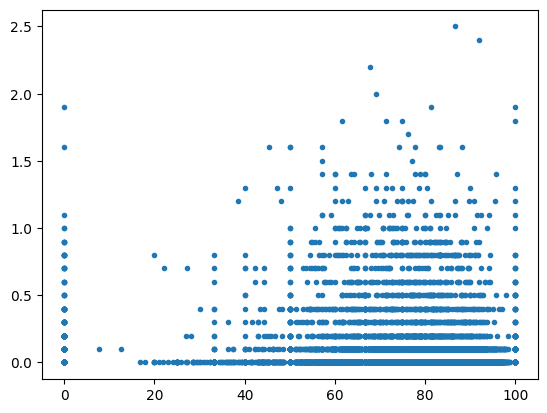

In [46]:
from matplotlib import pyplot as plt

# f = dataset.player.str.match('Harry Kane')
plt.plot(dataset.last_completed_passes_perc, dataset.xg, '.')
plt.show()